<a href="https://colab.research.google.com/github/szh141/UVA-AMF/blob/main/Stardist_GitHub_20241003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/maweigert/neubias_academy_stardist/blob/master/notebooks/stardist_example_2D_colab.ipynb

256x256x1 training data

QuPath annotation

https://www.youtube.com/watch?v=9G6uaoC18WA


# switch to GPU for faster training

In [ ]:
!pip install stardist

In [ ]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, normalize

from stardist.matching import matching_dataset
from stardist import fill_label_holes, random_label_cmap, relabel_image_stardist, calculate_extents, gputools_available, _draw_polygons
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
download_and_extract_zip_file(
    url       = 'https://github.com/mpicbg-csbd/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


In [ ]:
fX = sorted(Path('data/dsb2018/train/images/').glob('*.tif'))
fY = sorted(Path('data/dsb2018/train/masks').glob('*.tif'))
print(f"found {len(fX)} training images and {len(fY)} training masks")
assert all(Path(x).name==Path(y).name for x,y in zip(fX,fY))

found 447 training images and 447 training masks


# Load only a small subset for display

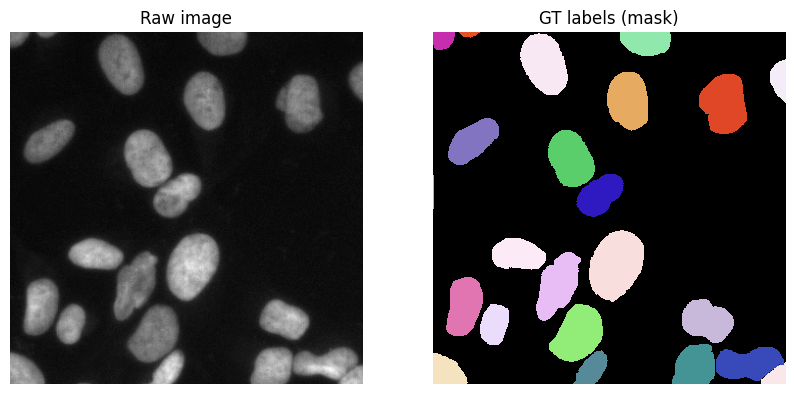

In [ ]:
fX_small, fY_small = fX[:10], fY[:10]

X_small = list(map(imread,map(str,fX_small)))
Y_small = list(map(imread,map(str,fY_small)))

i = min(4, len(X_small)-1)
img, lbl = X_small[i], fill_label_holes(Y_small[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')
None;

In [ ]:
n_rays = [2**i for i in range(2,8)]
print(n_rays)

[4, 8, 16, 32, 64, 128]


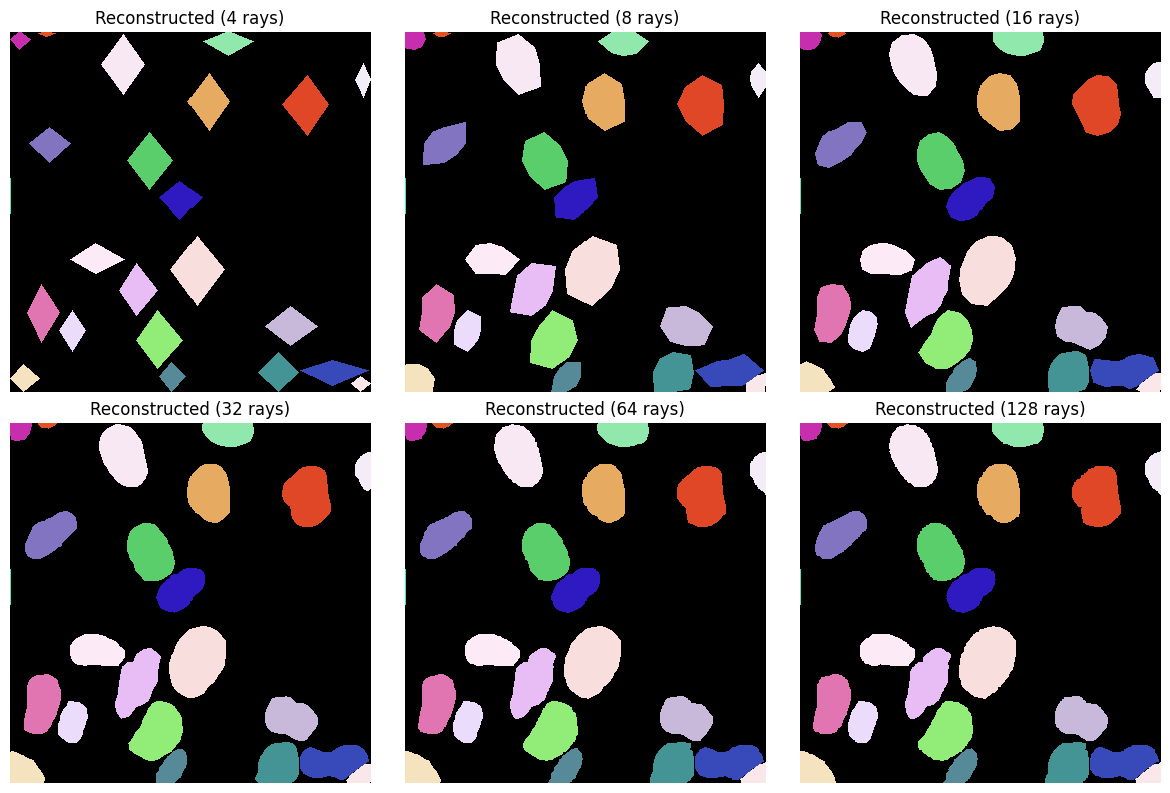

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(12,8))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap, interpolation="nearest")
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

100%|██████████| 6/6 [00:15<00:00,  2.54s/it]


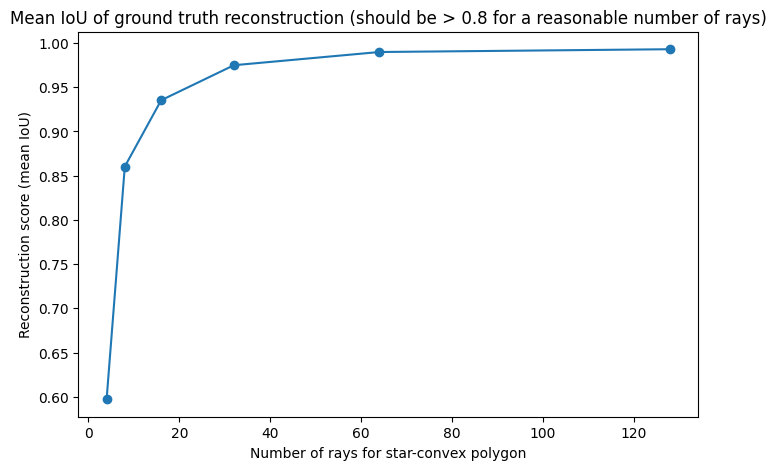

In [ ]:
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y_small]
    mean_iou = matching_dataset(Y_small, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean IoU)')
plt.title("Mean IoU of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

# training

In [ ]:
fX = sorted(Path('data/dsb2018/train/images/').glob('*.tif'))
fY = sorted(Path('data/dsb2018/train/masks').glob('*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(fX,fY))
print(f"{len(fX)} files found")

447 files found


In [ ]:
X = list(map(imread,map(str,tqdm(fX))))
Y = list(map(imread,map(str,tqdm(fY))))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

100%|██████████| 447/447 [00:00<00:00, 560.26it/s]


# normalize

In [ ]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 447/447 [00:03<00:00, 119.70it/s]


In [ ]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 447
- training:       380
- validation:      67


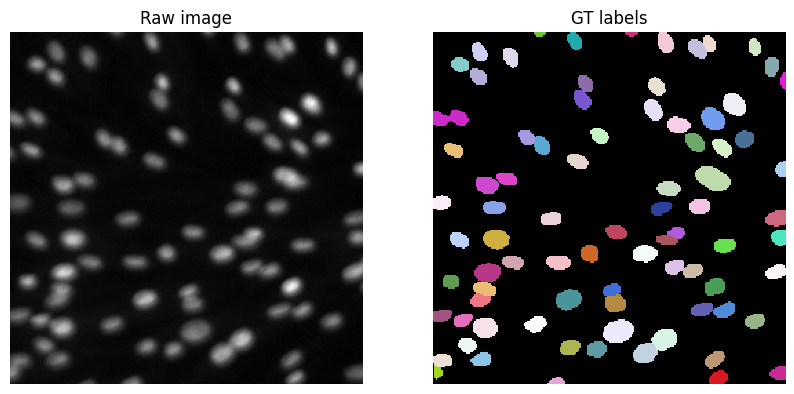

In [ ]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(10,8))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels')
None;

# config file

In [ ]:
print(Config2D.__doc__)

In [ ]:
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    n_channel_in = 1,
)
print(conf)
vars(conf)

In [ ]:
model = StarDist2D(conf, name='stardist', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")
else:
    print("All good! (object sizes fit into field of view of the neural network)")

All good! (object sizes fit into field of view of the neural network)


# Augmentation

In [ ]:
def random_fliprot(img, mask):
    axes = tuple(range(img.ndim))
    perm = np.random.permutation(axes)
    img = img.transpose(perm)
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand()>.5:
            img = np.flip(img,axis = ax)
            mask = np.flip(mask,axis = ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-.2,.2)
    return img


def augmenter(img,mask):
    """Augmentation for image,mask"""
    img, mask = random_fliprot(img, mask)
    img = random_intensity_change(img)
    return img, mask

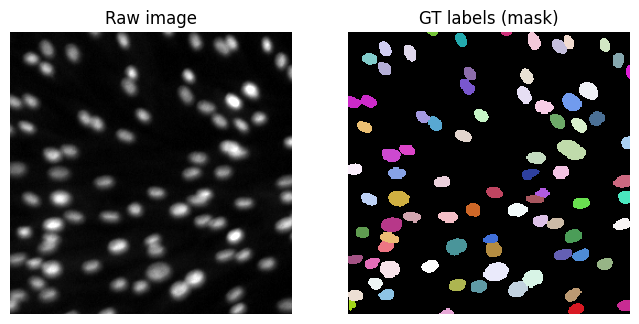

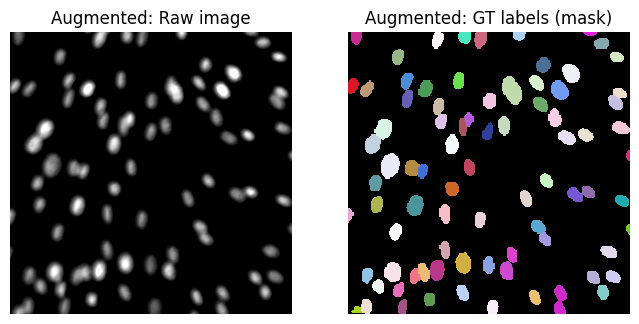

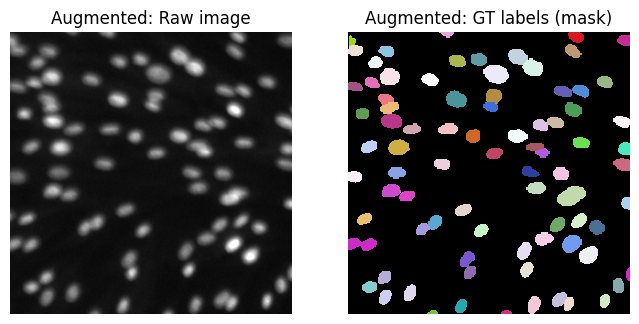

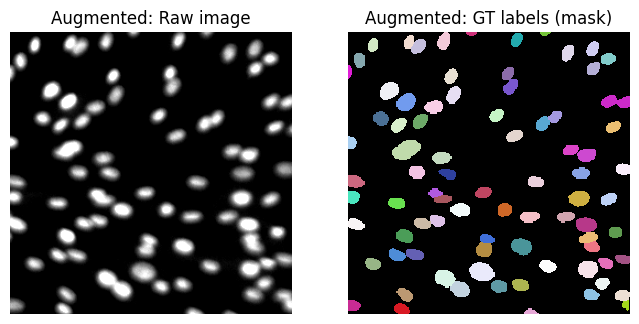

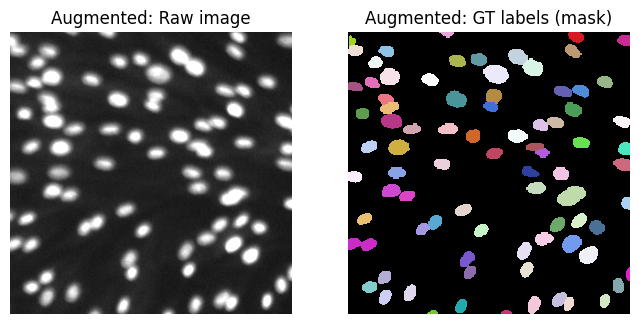

In [ ]:
plt.figure(figsize=(8,5))
plt.subplot(121); plt.imshow(img,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('GT labels (mask)')

for _ in range(4):
    plt.figure(figsize=(8,5))
    x,y = augmenter(img, lbl)
    plt.subplot(121); plt.imshow(x,cmap='gray', clim = (0,1));   plt.axis('off'); plt.title('Augmented: Raw image')
    plt.subplot(122); plt.imshow(y,cmap=lbl_cmap, interpolation="nearest"); plt.axis('off'); plt.title('Augmented: GT labels (mask)')
None;

In [ ]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=40, steps_per_epoch=25)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained("2D_versatile_fluo")
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - dist_dist_iou_metric: 0.0753 - dist_relevant_mae: 11.7066 - dist_relevant_mse: 247.5574 - loss: 2.7790 - prob_kld: 0.3581 - val_dist_dist_iou_metric: 0.2875 - val_dist_relevant_mae: 7.3597 - val_dist_relevant_mse: 119.5818 - val_loss: 1.7679 - val_prob_kld: 0.2221 - learning_rate: 3.0000e-04
Epoch 2/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - dist_dist_iou_metric: 0.3357 - dist_relevant_mae: 7.0148 - dist_relevant_mse: 102.6386 - loss: 1.6909 - prob_kld: 0.2123 - val_dist_dist_iou_metric: 0.2607 - val_dist_relevant_mae: 7.5257 - val_dist_relevant_mse: 126.4745 - val_loss: 1.7895 - val_prob_kld: 0.2105 - learning_rate: 3.0000e-04
Epoch 3/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - dist_dist_iou_metric: 0.3459 - dist_relevant_mae: 6.4538 - dist_relevant_mse: 89.1473 - loss: 1.5638 - prob_kld: 0.1965 - val_dist_dist_iou_metric: 0.3003 - val_dist_relevant_mae: 6.6450 - val_dist_relevant_mse: 101.1127 - val_loss: 1.5559 - val_p

In [ ]:
if not quick_demo:
    model.optimize_thresholds(X_val, Y_val)